# Introduction

In recent years, self-supervised learning and contrastive learning have gained significant attention as powerful techniques for learning useful data representations without the need for explicit labels. These approaches are particularly valuable in fields like natural language processing (NLP), computer vision, and recommendation systems, where obtaining labeled data can be time-consuming and expensive.

Self-supervised learning leverages unlabeled data to create pretext tasks, allowing models to learn robust feature representations that can be used for various downstream tasks such as classification, detection, and similarity search. Contrastive learning, a key method within the self-supervised learning framework, focuses on learning by comparing positive pairs (similar data points) and negative pairs (dissimilar data points) to maximize the similarity of the positive pairs while minimizing that of the negative pairs.

In this notebook, we will explore the principles of self-supervised and contrastive learning, focusing on how these techniques can be applied to image datasets like CIFAR-10. Through hands-on experiments, we will train models using contrastive learning methods and analyze their performance, exploring the potential benefits of these approaches in real-world scenarios.

# Import Libraries

In [2]:
import time
import torch
import math
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, Subset
import random
from PIL import Image, ImageOps
import numpy as np
import os
import random
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from tqdm.auto import tqdm
from torchvision.transforms import RandAugment
import torch.optim as optim

# Baseline

## Dataset

In real-world training scenarios, it's common to have access to only a subset label of the full dataset. For this example, we will use a subset of the CIFAR-10 dataset, specifically 5000 samples, and train a basic model to evaluate its accuracy and loss. Complete #TODO parts.

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.49139968, 0.48215827, 0.44653124), (0.24703233, 0.24348505, 0.26158768))]
)

batch_size = 100

train_dataset = datasets.CIFAR10(download=True, root='./data', train=True, transform=transform)
train_dataset = Subset(train_dataset, list(range(5000)))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = datasets.CIFAR10(download=True, root='./data', train=False, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

100%|██████████| 170M/170M [00:13<00:00, 12.9MB/s] 


## Model

Next, create a simple network to train on the CIFAR-10 subset and report its loss and accuracy.

In [5]:
class Network(nn.Module):
    """
      A simple convolutional neural network designed for image classification on the CIFAR-10 dataset.

      The network should consists of:
      - A `self.backbone` containing convolutional layers, ReLU activations, and batch normalization,
      - A `self.fc` layer that flattens the feature map and reduces its dimensions,
      - A `self.classification_head` that outputs predictions for a given number of classes (default is 10, suitable for CIFAR-10).

      Args:
          num_classes (int): The number of output classes for classification. Defaults to 10 for CIFAR-10.

      Methods:
          forward(x):
              Defines the forward pass through the network.
    """
    def __init__(self, num_classes=10):
        super(Network, self).__init__()
        self.backbone = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            
            nn.Flatten(),
        )
        
        self.fc = nn.Sequential(
            nn.LazyLinear(32),
            nn.ReLU(),
        )
        self.classification_head = nn.LazyLinear(num_classes)

    def forward(self, x):
        x = self.backbone(x)             
        x = self.fc(x)                   
        logits = self.classification_head(x)  
        return logits

## Train and Test

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Network().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

num_epochs = 10


train_losses, train_accs = [], []
test_losses, test_accs = [], []

for epoch in range(1, num_epochs + 1):
    
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0

    pbar = tqdm(train_loader, desc=f"[Train] Epoch {epoch}/{num_epochs}")
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        batch_size = images.size(0)
        running_loss += loss.item() * batch_size
        preds = outputs.argmax(dim=1)
        running_corrects += (preds == labels).sum().item()
        total_samples += batch_size

        avg_loss = running_loss / total_samples
        avg_acc  = running_corrects / total_samples * 100
        pbar.set_postfix(loss=f"{avg_loss:.4f}", acc=f"{avg_acc:.2f}%")

    train_losses.append(avg_loss)
    train_accs.append(avg_acc)
    print(f"→ Epoch {epoch:2d}: Train Loss = {avg_loss:.4f}, Train Acc = {avg_acc:.2f}%")

    model.eval()
    test_running_loss = 0.0
    test_running_corrects = 0
    test_total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            bs = images.size(0)
            test_running_loss += loss.item() * bs
            preds = outputs.argmax(dim=1)
            test_running_corrects += (preds == labels).sum().item()
            test_total += bs

    test_epoch_loss = test_running_loss / test_total
    test_epoch_acc  = test_running_corrects / test_total * 100
    test_losses.append(test_epoch_loss)
    test_accs.append(test_epoch_acc)

    print(f"→ Epoch {epoch:2d}: Test  Loss = {test_epoch_loss:.4f}, Test  Acc = {test_epoch_acc:.2f}%")


[Train] Epoch 1/10:   0%|          | 0/50 [00:00<?, ?it/s]

→ Epoch  1: Train Loss = 1.8397, Train Acc = 33.32%
→ Epoch  1: Test  Loss = 1.5916, Test  Acc = 42.26%


[Train] Epoch 2/10:   0%|          | 0/50 [00:00<?, ?it/s]

→ Epoch  2: Train Loss = 1.3469, Train Acc = 52.14%
→ Epoch  2: Test  Loss = 1.4319, Test  Acc = 48.37%


[Train] Epoch 3/10:   0%|          | 0/50 [00:00<?, ?it/s]

→ Epoch  3: Train Loss = 1.0300, Train Acc = 64.32%
→ Epoch  3: Test  Loss = 1.4349, Test  Acc = 49.21%


[Train] Epoch 4/10:   0%|          | 0/50 [00:00<?, ?it/s]

→ Epoch  4: Train Loss = 0.7662, Train Acc = 75.54%
→ Epoch  4: Test  Loss = 1.4455, Test  Acc = 50.83%


[Train] Epoch 5/10:   0%|          | 0/50 [00:00<?, ?it/s]

→ Epoch  5: Train Loss = 0.4939, Train Acc = 85.68%
→ Epoch  5: Test  Loss = 1.5366, Test  Acc = 50.70%


[Train] Epoch 6/10:   0%|          | 0/50 [00:00<?, ?it/s]

→ Epoch  6: Train Loss = 0.2871, Train Acc = 93.12%
→ Epoch  6: Test  Loss = 1.6609, Test  Acc = 50.58%


[Train] Epoch 7/10:   0%|          | 0/50 [00:00<?, ?it/s]

→ Epoch  7: Train Loss = 0.1440, Train Acc = 97.36%
→ Epoch  7: Test  Loss = 1.7491, Test  Acc = 51.15%


[Train] Epoch 8/10:   0%|          | 0/50 [00:00<?, ?it/s]

→ Epoch  8: Train Loss = 0.0619, Train Acc = 99.64%
→ Epoch  8: Test  Loss = 1.8412, Test  Acc = 50.63%


[Train] Epoch 9/10:   0%|          | 0/50 [00:00<?, ?it/s]

→ Epoch  9: Train Loss = 0.0265, Train Acc = 99.92%
→ Epoch  9: Test  Loss = 1.9068, Test  Acc = 51.06%


[Train] Epoch 10/10:   0%|          | 0/50 [00:00<?, ?it/s]

→ Epoch 10: Train Loss = 0.0136, Train Acc = 100.00%
→ Epoch 10: Test  Loss = 1.9753, Test  Acc = 51.64%


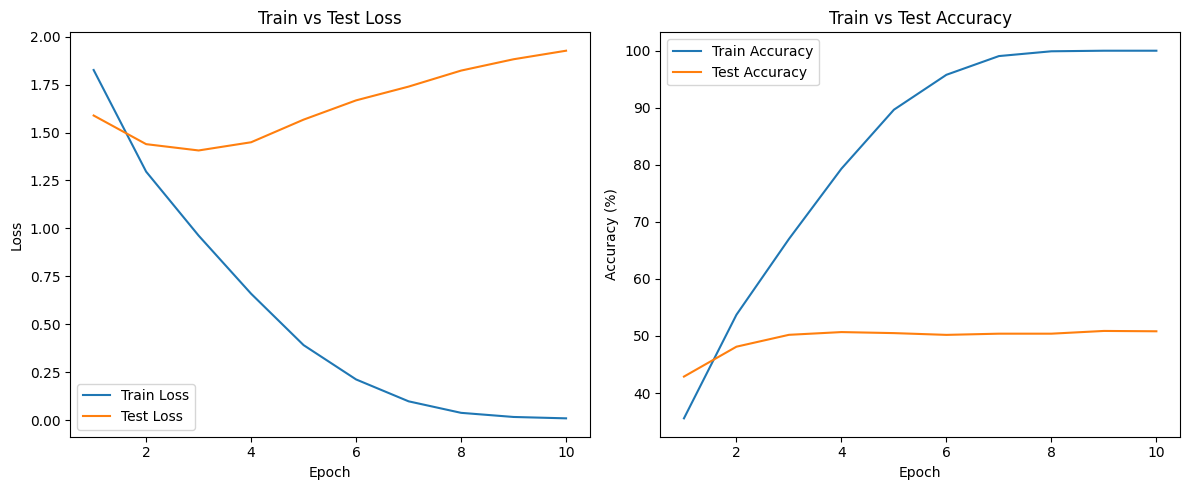

In [5]:
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses,     label='Train Loss')
plt.plot(epochs, test_losses,      label='Test Loss')
plt.title('Train vs Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accs,       label='Train Accuracy')
plt.plot(epochs, test_accs,        label='Test Accuracy')
plt.title('Train vs Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

# Self Supervised Learning

Now, we want to apply self-supervised methods by first training the model on augmented data, and then training the model on the real labeled data to observe the effects of this approach.

To create the augmented data, define a CIFAR10PretextDataset class that applies random transformations to the images. These transformations should include:

Rotating the image by one of the following angles: 0°, 90°, 180°, or 270°.

Shearing the image by one of the following factors: 0.0, 0.2, or 0.4.

Changing the color mode of the image to one of the following: 'original', 'grayscale', or 'color_inverted'.

After that, create a network that predicts these transformations as well as the image labels. Train the model using the first 1000 samples from the CIFAR-10 dataset. Ensure that the network has the same backbone as the baseline model to make a fair comparison.

In [6]:
    class CIFAR10PretextDataset(Dataset):
        """
        A custom dataset class for applying self-supervised learning pretext tasks on the CIFAR-10 dataset.
    
        This class augments the CIFAR-10 images with random transformations to create pretext tasks for self-supervised learning.
        The transformations applied include:
        - Random rotations (0°, 90°, 180°, 270°),
        - Random shearing (0.0, 0.2, 0.4),
        - Random color mode changes (original, grayscale, color inverted).
    
        The goal of these transformations is to create a task where the model must predict the type of transformation applied to the image, which can then be used as a self-supervised learning task.
    
        Args:
            root (str): Directory where the CIFAR-10 dataset will be stored or loaded from.
            train (bool): Whether to load the training dataset (True) or test dataset (False).
            transform (callable, optional): A function/transform to apply to the image (default is None).
    
        Attributes:
            dataset (torchvision.datasets.CIFAR10): The CIFAR-10 dataset.
            rotation_angles (list): List of angles (0°, 90°, 180°, 270°) for random rotations.
            shear_factors (list): List of shear factors (0.0, 0.2, 0.4) for random shearing.
            color_modes (list): List of color modes ('original', 'grayscale', 'color_inverted') for random color transformations.
    
        Methods:
            __len__(): Returns the total number of samples in the dataset.
            __getitem__(idx): Returns an augmented image and its corresponding label (rotational, shear, and color transformation indices).
        """
    
        def __init__(self, root, train=True, transform=None):
            self.dataset = torchvision.datasets.CIFAR10(root=root, train=train, download=True)
            self.transform = transform
    
            self.rotation_angles = [0, 90, 180, 270]
            self.shear_factors = [0.0, 0.2, 0.4]
            self.color_modes = ['original', 'grayscale', 'color_inverted']
    
        def __len__(self):
            return len(self.dataset)
    
        def __getitem__(self, idx):
            img, _ = self.dataset[idx]
    
            rot_idx = random.randrange(len(self.rotation_angles))
            angle = self.rotation_angles[rot_idx]

            
            shear_idx    = random.randrange(len(self.shear_factors))
            shear_factor = self.shear_factors[shear_idx]
            shear_angle  = math.degrees(math.atan(shear_factor))
            
            color_idx = random.randrange(len(self.color_modes))
            mode = self.color_modes[color_idx]
    
    
            img = transforms.RandomAffine(degrees=(angle, angle), shear=(shear_angle, shear_angle))(img)
            
    
            if mode == 'grayscale':
                img = transforms.functional.rgb_to_grayscale(img, num_output_channels=3)
            elif mode == 'color_inverted':
                img = transforms.functional.invert(img)
    
            img = self.transform(img)
    

            return img, (rot_idx, shear_idx, color_idx)


In [7]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.49139968, 0.48215827, 0.44653124), (0.24703233, 0.24348505, 0.26158768))]
)
batch_size = 100


train_dataset = CIFAR10PretextDataset(root='./data', train=True, transform=transform)
self_supervised_train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)

test_dataset = CIFAR10PretextDataset(root='./data', train=False, transform=transform)
self_supervised_test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=8)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Now implement the model.

In [8]:
class Supervised_Learning(nn.Module):
    def __init__(self, num_classes = 10):
        """
        Initialize the Supervised_Learning model.
        Note that the backbone should be the same as the baseline model.
        Init seperate head for rotation, shear, color and classification.
        Args:
            num_classes (int): Number of output classes for classification.
        """
        # =========================== TODO ===========================
        super(Supervised_Learning, self).__init__()
        self.backbone = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),  # input channels changed to 3
            nn.ReLU(),
            nn.BatchNorm2d(32),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            
            nn.Flatten(),
        )
        self.fc = nn.Sequential(
            nn.LazyLinear(32),
            nn.ReLU(),
        )

        self.rotation_head = nn.LazyLinear(4)
        self.shear_head = nn.LazyLinear(3)
        self.color_head = nn.LazyLinear(3)
        self.classification_head = nn.LazyLinear(num_classes)

        # ============================================================

    def extract_features(self, x):
        x = self.backbone(x)
        return x

    def forward(self, x):
        
        feats = self.extract_features(x)
        h = self.fc(feats)
        
        rot_out = self.rotation_head(h)
        shear_out = self.shear_head(h)
        color_out = self.color_head(h)
        
        class_out = self.classification_head(h)
        
        return rot_out, shear_out, color_out, class_out


In [21]:
# Report the training and test accuracy for the self-supervised tasks.

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Supervised_Learning().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

def evaluate(loader):
    model.eval()
    correct = {'rot':0, 'shear':0, 'color':0}
    total   = 0
    with torch.no_grad():
        for imgs, (r_lbl, s_lbl, c_lbl) in loader:
            imgs = imgs.to(device)
            r_lbl = r_lbl.to(device)
            s_lbl = s_lbl.to(device)
            c_lbl = c_lbl.to(device)

            r_out, s_out, c_out, _ = model(imgs)
            # preds
            r_pred = r_out.argmax(1)
            s_pred = s_out.argmax(1)
            c_pred = c_out.argmax(1)

            correct['rot']   += (r_pred == r_lbl).sum().item()
            correct['shear'] += (s_pred == s_lbl).sum().item()
            correct['color'] += (c_pred == c_lbl).sum().item()
            total += imgs.size(0)

    return {k: v/total*100 for k,v in correct.items()}


num_epochs = 30
for epoch in range(1, num_epochs+1):

    model.train()
    running_loss = 0.0

    for imgs, (r_lbl, s_lbl, c_lbl) in self_supervised_train_loader:
        imgs = imgs.to(device)
        r_lbl, s_lbl, c_lbl = r_lbl.to(device), s_lbl.to(device), c_lbl.to(device)

        optimizer.zero_grad()
        r_out, s_out, c_out, _ = model(imgs)

        loss_r = criterion(r_out, r_lbl)
        loss_s = criterion(s_out, s_lbl)
        loss_c = criterion(c_out, c_lbl)
        loss   = loss_r + loss_s + loss_c
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)

    train_loss = running_loss / len(self_supervised_train_loader.dataset)
    train_acc  = evaluate(self_supervised_train_loader)
    test_acc   = evaluate(self_supervised_test_loader)

    print(
        f"Epoch {epoch:2d} -- Train loss: {train_loss:.4f} \n"
        f"Train Acc — rot: {train_acc['rot']:.1f}%, shear: {train_acc['shear']:.1f}%, color: {train_acc['color']:.1f}% \n"
        f"Test Acc — rot: {test_acc['rot']:.1f}%, shear: {test_acc['shear']:.1f}%, color: {test_acc['color']:.1f}% \n"
        f"=================================================="
    )

Epoch  1 -- Train loss: 1.1339 
Train Acc — rot: 63.3%, shear: 99.1%, color: 94.2% 
Test Acc — rot: 63.9%, shear: 99.3%, color: 94.2% 
Epoch  2 -- Train loss: 0.9143 
Train Acc — rot: 65.1%, shear: 99.4%, color: 94.8% 
Test Acc — rot: 64.8%, shear: 99.5%, color: 94.4% 
Epoch  3 -- Train loss: 0.8705 
Train Acc — rot: 66.4%, shear: 99.4%, color: 95.4% 
Test Acc — rot: 66.0%, shear: 99.4%, color: 95.5% 
Epoch  4 -- Train loss: 0.8453 
Train Acc — rot: 68.1%, shear: 99.4%, color: 95.4% 
Test Acc — rot: 67.7%, shear: 99.4%, color: 95.7% 
Epoch  5 -- Train loss: 0.8128 
Train Acc — rot: 69.1%, shear: 99.5%, color: 95.7% 
Test Acc — rot: 68.7%, shear: 99.5%, color: 95.9% 
Epoch  6 -- Train loss: 0.7973 
Train Acc — rot: 69.9%, shear: 99.5%, color: 96.2% 
Test Acc — rot: 69.6%, shear: 99.5%, color: 95.9% 
Epoch  7 -- Train loss: 0.7766 
Train Acc — rot: 69.3%, shear: 99.6%, color: 95.7% 
Test Acc — rot: 68.6%, shear: 99.7%, color: 95.4% 
Epoch  8 -- Train loss: 0.7668 
Train Acc — rot: 70.8%,

Next, train and evaluate the model using the true labels, and compare its performance with the baseline model.

In [26]:
# ======================= TODO =======================

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for param in model.backbone.parameters():
    param.requires_grad = False

# for param in model.fc.parameters():
#     param.requires_grad = True


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    list(model.fc.parameters()) + list(model.classification_head.parameters()),
    lr=1e-3,
    weight_decay=1e-4
)

num_epochs = 40

train_losses, train_accs = [], []
test_losses, test_accs = [], []

for epoch in range(31, num_epochs + 1):
    
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0

    pbar = tqdm(train_loader, desc=f"[Train] Epoch {epoch}/{num_epochs}")
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        _, _, _, outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        batch_size = images.size(0)
        running_loss += loss.item() * batch_size
        preds = outputs.argmax(dim=1)
        running_corrects += (preds == labels).sum().item()
        total_samples += batch_size

        avg_loss = running_loss / total_samples
        avg_acc  = running_corrects / total_samples * 100
        pbar.set_postfix(loss=f"{avg_loss:.4f}", acc=f"{avg_acc:.2f}%")

    train_losses.append(avg_loss)
    train_accs.append(avg_acc)
    print(f"→ Epoch {epoch:2d}: Train Loss = {avg_loss:.4f}, Train Acc = {avg_acc:.2f}%")

    model.eval()
    test_running_loss = 0.0
    test_running_corrects = 0
    test_total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            _, _, _, outputs = model(images)
            loss = criterion(outputs, labels)

            bs = images.size(0)
            test_running_loss += loss.item() * bs
            preds = outputs.argmax(dim=1)
            test_running_corrects += (preds == labels).sum().item()
            test_total += bs

    test_epoch_loss = test_running_loss / test_total
    test_epoch_acc  = test_running_corrects / test_total * 100
    test_losses.append(test_epoch_loss)
    test_accs.append(test_epoch_acc)

    print(f"→ Epoch {epoch:2d}: Test  Loss = {test_epoch_loss:.4f}, Test  Acc = {test_epoch_acc:.2f}%")


# ====================================================

[Train] Epoch 31/40:   0%|          | 0/50 [00:00<?, ?it/s]

→ Epoch 31: Train Loss = 0.0327, Train Acc = 99.98%
→ Epoch 31: Test  Loss = 2.0576, Test  Acc = 53.80%


[Train] Epoch 32/40:   0%|          | 0/50 [00:00<?, ?it/s]

→ Epoch 32: Train Loss = 0.0277, Train Acc = 100.00%
→ Epoch 32: Test  Loss = 2.0685, Test  Acc = 53.92%


[Train] Epoch 33/40:   0%|          | 0/50 [00:00<?, ?it/s]

→ Epoch 33: Train Loss = 0.0272, Train Acc = 100.00%
→ Epoch 33: Test  Loss = 2.1067, Test  Acc = 53.76%


[Train] Epoch 34/40:   0%|          | 0/50 [00:00<?, ?it/s]

→ Epoch 34: Train Loss = 0.0232, Train Acc = 100.00%
→ Epoch 34: Test  Loss = 2.1212, Test  Acc = 53.85%


[Train] Epoch 35/40:   0%|          | 0/50 [00:00<?, ?it/s]

→ Epoch 35: Train Loss = 0.0225, Train Acc = 100.00%
→ Epoch 35: Test  Loss = 2.1297, Test  Acc = 53.95%


[Train] Epoch 36/40:   0%|          | 0/50 [00:00<?, ?it/s]

→ Epoch 36: Train Loss = 0.0203, Train Acc = 100.00%
→ Epoch 36: Test  Loss = 2.1494, Test  Acc = 53.93%


[Train] Epoch 37/40:   0%|          | 0/50 [00:00<?, ?it/s]

→ Epoch 37: Train Loss = 0.0202, Train Acc = 99.98%
→ Epoch 37: Test  Loss = 2.1753, Test  Acc = 53.90%


[Train] Epoch 38/40:   0%|          | 0/50 [00:00<?, ?it/s]

→ Epoch 38: Train Loss = 0.0178, Train Acc = 100.00%
→ Epoch 38: Test  Loss = 2.1768, Test  Acc = 53.96%


[Train] Epoch 39/40:   0%|          | 0/50 [00:00<?, ?it/s]

→ Epoch 39: Train Loss = 0.0160, Train Acc = 100.00%
→ Epoch 39: Test  Loss = 2.2055, Test  Acc = 53.89%


[Train] Epoch 40/40:   0%|          | 0/50 [00:00<?, ?it/s]

→ Epoch 40: Train Loss = 0.0151, Train Acc = 100.00%
→ Epoch 40: Test  Loss = 2.2092, Test  Acc = 53.84%


As expected, the new model outperforms the baseline. The reseason is in accord to our intuition. it has learned meaningful patterns and features in its backbone and now does the clasification more accurately.

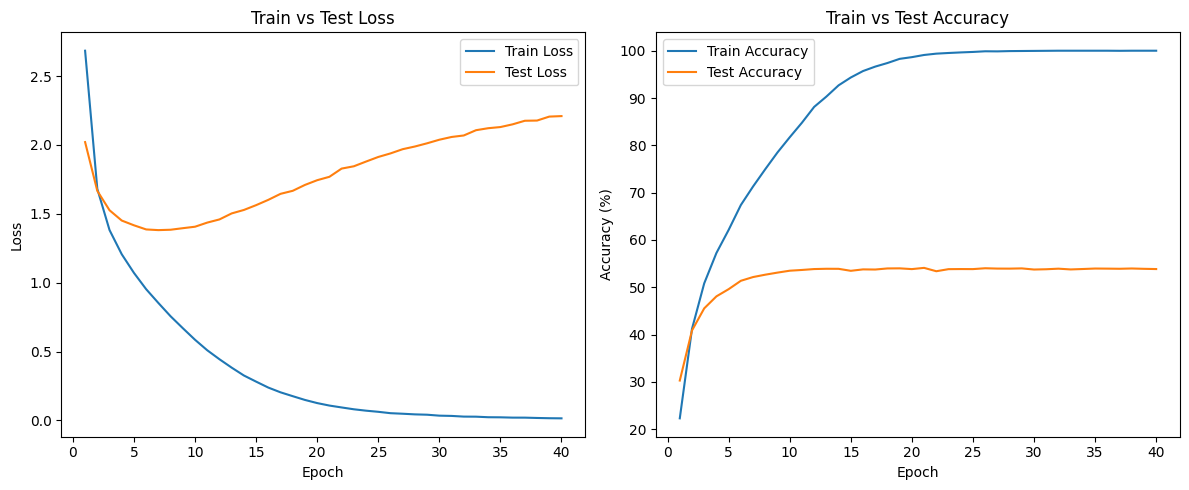

In [27]:
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses,     label='Train Loss')
plt.plot(epochs, test_losses,      label='Test Loss')
plt.title('Train vs Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accs,       label='Train Accuracy')
plt.plot(epochs, test_accs,        label='Test Accuracy')
plt.title('Train vs Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

To evaluate the quality of the learned features, complete the function find_top_10_closest_samples. This function should extract features from images using only the self.backbone of the model (not the full classification head), and then compute the top 10 most similar samples for a few randomly chosen test images based on Euclidean distance in the feature space.

Once completed, run the function and analyze the results. The goal is to visually inspect whether the model groups similar images together in its learned feature space, which is especially important for understanding the effectiveness of self-supervised learning.

This qualitative evaluation helps determine whether the backbone is capturing meaningful patterns, even without relying on labels during training.

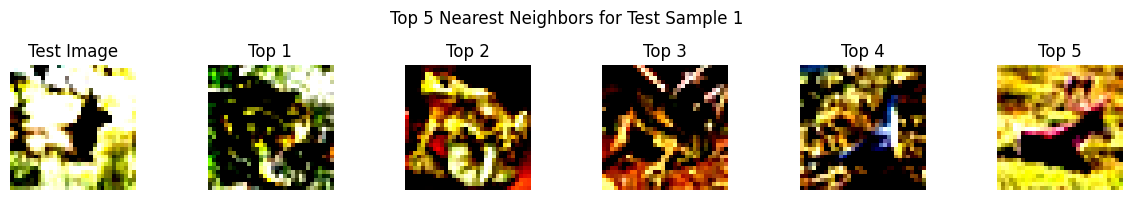

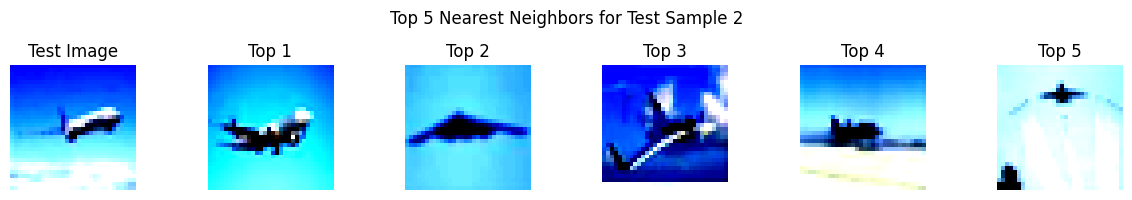

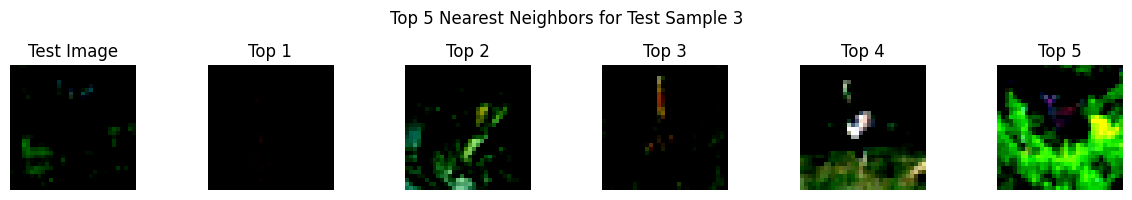

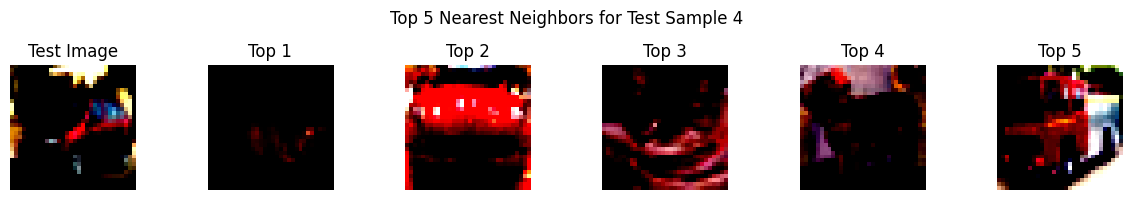

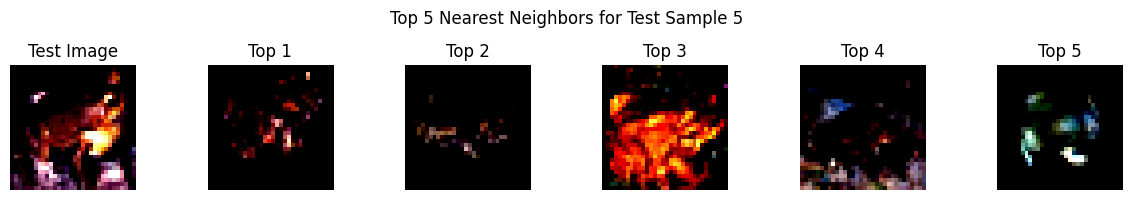

In [31]:
from torchvision.utils import make_grid

def find_top_k_closest_samples(model, train_loader, test_loader, device, sample_size=5, k=10):
    model.eval()
    
  
    train_features = []
    train_images = []

    with torch.no_grad():
        for imgs, _ in train_loader:
            imgs = imgs.to(device)
            feats = model.extract_features(imgs)
            train_features.append(feats.cpu())
            train_images.append(imgs.cpu())
    
    train_features = torch.cat(train_features, dim=0)  
    train_images = torch.cat(train_images, dim=0)      

  
    test_images_sampled = []
    test_features_sampled = []

    with torch.no_grad():
        for imgs, _ in test_loader:
            imgs = imgs.to(device)
            feats = model.extract_features(imgs)
            test_images_sampled.append(imgs.cpu())
            test_features_sampled.append(feats.cpu())

            if len(test_images_sampled) * imgs.size(0) >= sample_size:
                break
    
    test_images_sampled = torch.cat(test_images_sampled, dim=0)[:sample_size]
    test_features_sampled = torch.cat(test_features_sampled, dim=0)[:sample_size]

  
    for i in range(sample_size):
        test_feat = test_features_sampled[i] 
        dists = torch.norm(train_features - test_feat, dim=1) 
        topk_indices = torch.topk(dists, k, largest=False).indices  

 
        fig, axes = plt.subplots(1, k + 1, figsize=(2 * (k + 1), 2))
        axes[0].imshow(test_images_sampled[i].permute(1, 2, 0))
        axes[0].set_title("Test Image")
        axes[0].axis('off')

        for j in range(k):
            neighbor_img = train_images[topk_indices[j]]
            axes[j + 1].imshow(neighbor_img.permute(1, 2, 0))
            axes[j + 1].set_title(f"Top {j + 1}")
            axes[j + 1].axis('off')

        plt.suptitle(f"Top {k} Nearest Neighbors for Test Sample {i+1}")
        plt.tight_layout()
        plt.show()


find_top_k_closest_samples(model, train_loader, test_loader, device, k = 5)

Again as we expected, the model has learned to identify close images. the images in each group have similar texture or even the same object. for example all images in sample 1 contain an airplane, all images in sample 3 have similar texture, etc.

# Contrastive Learning

Now it’s time for some contrastive learning. To mitigate the issue of insufficient annotation labels and fully utilize the large quantity of unlabelled data, contrastive learning could be used to effectively help the backbone learn the data representations without a specific task. The backbone could be frozen for a given downstream task and only train a shallow network on a limited annotated dataset to achieve satisfactory results.

The most commonly used contrastive learning approaches include SimCLR, SimSiam, and MOCO. Here, we want to learn SimSiam.

SimCLR calculates over positive and negative pairs within the data batch, which requires hard negative mining, NT-Xent loss (which extends the cosine similarity loss over a batch) and a large batch size. SimCLR also requires the LARS optimizer to accommodate a large batch size.

SimSiam, however, uses a Siamese architecture, which avoids using negative pairs and further avoids the need for large batch sizes. The differences between SimSiam and SimCLR are given in the table below.

![Alt text](https://miro.medium.com/v2/resize:fit:1100/format:webp/1*HGV5hcd8bhkMa5PiupN3jg.png)


![Alt text](https://miro.medium.com/v2/resize:fit:720/format:webp/1*L-7z34l5UCkGCO0zqiK8jw.png)


We can see from the figure above that the SimSiam architecture only contains two parts: the encoder/backbone and the predictor. During training time, the gradient propagation of the Siamese part is stopped, and the cosine similarity is calculated between the outputs of the predictors and the backbone.

So, how do we implement this architecture in reality? Continuing on the supervised classification design, we keep the backbone the same and only modify the MLP layer. In the supervised learning architecture, the MLP outputs a 10-element vector indicating the probabilities of the 10 classes. But for SimSiam, the purpose is not to perform “classification” but to learn the “representation,” so we need the output to be of the same dimension as the backbone output for loss calculation.

Use this description to guide your implementation. You may also refer to the SimSiam paper for additional details on the architecture and training process.



The pseudo-code for training the SimSiam is given in the original paper below:

![Alt text](https://miro.medium.com/v2/resize:fit:1100/format:webp/1*Lxf9twaUuVkofiLB1ir2fg.png)


In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet18

class SimSiam(nn.Module):
    """
    SimSiam with a ResNet-18 backbone for stronger CIFAR-10 representations.
    """
    def __init__(self, num_classes: int = 10):
        super().__init__()
        
        resnet = resnet18(pretrained=False)
        self.backbone = nn.Sequential(*list(resnet.children())[:-1], nn.Flatten())
        feat_dim = resnet.fc.in_features  # 512 for ResNet-18

        
        proj_hidden  = 2048
        proj_out_dim = 512
        self.projection = nn.Sequential(
            nn.Linear(feat_dim, proj_hidden, bias=False),
            nn.BatchNorm1d(proj_hidden),
            nn.ReLU(inplace=True),
            nn.Linear(proj_hidden, proj_out_dim, bias=True)
        )

        
        pred_hidden = 128
        pred_out_dim = proj_out_dim 
        self.prediction = nn.Sequential(
            nn.Linear(proj_out_dim, pred_hidden, bias=False),
            nn.BatchNorm1d(pred_hidden),
            nn.ReLU(inplace=True),
            nn.Linear(pred_hidden, pred_out_dim)
        )

    def forward(self, x: torch.Tensor):
        # Backbone + flatten
        feat = self.backbone(x)
        # Projected features
        z = self.projection(feat)
        # Predictor output
        p = self.prediction(z)
        return p, z


# Loss: negative cosine similarity with gradient stop on target
cos = nn.CosineSimilarity(dim=1, eps=1e-6)
def negative_cosine_similarity_stopgradient(p: torch.Tensor, z: torch.Tensor) -> torch.Tensor:
    z = z.detach()
    p = F.normalize(p, dim=1)
    z = F.normalize(z, dim=1)
    return - (p * z).sum(dim=1).mean()

Now, train the model using the SimSiam method on the training dataset.

Hint: To perform random augmentations on the input images, you can use `RandAugment` from `torchvision.transforms`.



In [37]:
import time
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.transforms import RandAugment
from torch.utils.data import DataLoader
from tqdm.auto import tqdm


class TwoCropsTransform:
    def __init__(self, base_transform):
        self.base_transform = base_transform

    def __call__(self, x):
        return self.base_transform(x), self.base_transform(x)


normalize = transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                                 std=[0.2470, 0.2435, 0.2616])

augmentation = transforms.Compose([
    transforms.RandomResizedCrop(32, scale=(0.5, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    RandAugment(num_ops=3, magnitude=7),
    transforms.ToTensor(),
    normalize,
])


train_dataset = datasets.CIFAR10(
    root="./data", train=True, download=True,
    transform=TwoCropsTransform(augmentation)
)

train_loader = DataLoader(
    train_dataset, batch_size=128, shuffle=True,
    num_workers=2, drop_last=True
)



device    = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model     = SimSiam().to(device)
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=0.05, momentum=0.9, weight_decay=1e-4
)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)




def train_one_epoch(model, loader, optimizer, device):
    model.train()
    total_loss = 0.0
    for (x1, x2), _ in loader:
        x1, x2 = x1.to(device), x2.to(device)
        p1, z1 = model(x1)
        p2, z2 = model(x2)

        loss = 0.5 * negative_cosine_similarity_stopgradient(p1, z2) + \
               0.5 * negative_cosine_similarity_stopgradient(p2, z1)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x1.size(0)

    n = len(loader.dataset) - (len(loader.dataset) % loader.batch_size)
    return total_loss / n


# training for 50 may be considered sufficient
# I had done the training for 50 epochs but it seemes the output was deleted for some reason. 

epochs = 50
for epoch in range(1, epochs + 1):
    start = time.time()
    loss = train_one_epoch(model, train_loader, optimizer, device)
    scheduler.step()
    print(f"Epoch [{epoch:02d}/{epochs}]  "
          f"Loss: {loss: .4f}  "
          f"LR: {optimizer.param_groups[0]['lr']:.5f}  "
          f"Time: {time.time() - start: .1f}s")


Epoch [11/20]  Loss: -0.8313  LR: 0.04426  Time:  53.4s
Epoch [12/20]  Loss: -0.8305  LR: 0.04322  Time:  54.2s
Epoch [13/20]  Loss: -0.8325  LR: 0.04211  Time:  54.4s
Epoch [14/20]  Loss: -0.8360  LR: 0.04094  Time:  54.7s
Epoch [15/20]  Loss: -0.8375  LR: 0.03969  Time:  55.6s
Epoch [16/20]  Loss: -0.8411  LR: 0.03840  Time:  56.7s
Epoch [17/20]  Loss: -0.8424  LR: 0.03704  Time:  53.6s
Epoch [18/20]  Loss: -0.8434  LR: 0.03564  Time:  53.3s
Epoch [19/20]  Loss: -0.8459  LR: 0.03420  Time:  54.4s
Epoch [20/20]  Loss: -0.8477  LR: 0.03273  Time:  55.4s


In [34]:
test_transform = transforms.Compose([
    transforms.ToTensor(),
    normalize,            
])


test_dataset = datasets.CIFAR10(
    root="./data",
    train=False,
    download=True,
    transform=test_transform
)

test_loader = DataLoader(
    test_dataset,
    batch_size=256,        
    shuffle=False,         
    num_workers=2,      
    pin_memory=True,        
    drop_last=False
)

In [38]:
import numpy as np
from tqdm import tqdm
import plotly.express as px
import umap.umap_ as umap
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


model.eval()
model.to(device)

features = []
labels = []
for batch_idx, (image, target) in enumerate(tqdm(test_loader, total=len(test_loader))):

    with torch.no_grad():

        proj, pred = model(image.to(device))

    features.extend(np.squeeze(pred.detach().cpu().numpy()).tolist())
    labels.extend(target.detach().cpu().numpy().tolist())

reducer = umap.UMAP(n_components=3, n_neighbors=10, metric="cosine")
projections = reducer.fit_transform(np.array(features))

px.scatter(projections, x=0, y=1,
    color=labels, labels={'color': 'Cifar10 Labels'}
)

100%|██████████| 40/40 [00:01<00:00, 25.47it/s]


Now that we have the correct representations, how can they benefit our classification problem? We simply load the trained SimSiam backbone into our classification model. However, instead of fine-tuning the whole architecture in the limited training set, we fine-tuned the linear layers and froze the backbone because we didn’t want to corrupt the representation already learned.

Hint: Freeze the `simsiam.backbone` layers and train only the layers where `param.requires_grad` is set to True.

In [40]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.49139968, 0.48215827, 0.44653124), (0.24703233, 0.24348505, 0.26158768))]
)

batch_size = 100

train_dataset = datasets.CIFAR10(download=True, root='./data', train=True, transform=transform)
train_dataset = Subset(train_dataset, list(range(5000)))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = datasets.CIFAR10(download=True, root='./data', train=False, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [59]:
class SimSiamLinearEval(nn.Module):
    def __init__(self, pretrained_model, num_classes=10):
        super().__init__()
        self.backbone = model.backbone 
        
        self.classifier = nn.Sequential(
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, num_classes)
        )

        for param in self.backbone.parameters():
            param.requires_grad = False

    def forward(self, x):
        with torch.no_grad(): 
            feats = self.backbone(x)  
        return self.classifier(feats)


In [64]:
# ======================= TODO =======================

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

linear_model = SimSiamLinearEval(model).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(linear_model.classifier.parameters(), lr=1e-3, weight_decay=0)


num_epochs = 30

train_losses, train_accs = [], []
test_losses, test_accs = [], []

for epoch in range(1, num_epochs + 1):
    
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0

    pbar = tqdm(train_loader, desc=f"[Train] Epoch {epoch}/{num_epochs}")
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = linear_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        batch_size = images.size(0)
        running_loss += loss.item() * batch_size
        preds = outputs.argmax(dim=1)
        running_corrects += (preds == labels).sum().item()
        total_samples += batch_size

        avg_loss = running_loss / total_samples
        avg_acc  = running_corrects / total_samples * 100
        pbar.set_postfix(loss=f"{avg_loss:.4f}", acc=f"{avg_acc:.2f}%")

    train_losses.append(avg_loss)
    train_accs.append(avg_acc)
    print(f"→ Epoch {epoch:2d}: Train Loss = {avg_loss:.4f}, Train Acc = {avg_acc:.2f}%")

    model.eval()
    test_running_loss = 0.0
    test_running_corrects = 0
    test_total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = linear_model(images)
            loss = criterion(outputs, labels)

            bs = images.size(0)
            test_running_loss += loss.item() * bs
            preds = outputs.argmax(dim=1)
            test_running_corrects += (preds == labels).sum().item()
            test_total += bs

    test_epoch_loss = test_running_loss / test_total
    test_epoch_acc  = test_running_corrects / test_total * 100
    test_losses.append(test_epoch_loss)
    test_accs.append(test_epoch_acc)

    print(f"→ Epoch {epoch:2d}: Test  Loss = {test_epoch_loss:.4f}, Test  Acc = {test_epoch_acc:.2f}%")


# ====================================================

[Train] Epoch 21/30: 100%|██████████| 50/50 [00:01<00:00, 32.45it/s, acc=39.44%, loss=1.6127]


→ Epoch 21: Train Loss = 1.6127, Train Acc = 39.44%
→ Epoch 21: Test  Loss = 1.6409, Test  Acc = 39.08%


[Train] Epoch 22/30: 100%|██████████| 50/50 [00:01<00:00, 32.77it/s, acc=41.00%, loss=1.5703]


→ Epoch 22: Train Loss = 1.5703, Train Acc = 41.00%
→ Epoch 22: Test  Loss = 1.6223, Test  Acc = 39.66%


[Train] Epoch 23/30: 100%|██████████| 50/50 [00:01<00:00, 32.23it/s, acc=43.14%, loss=1.5415]


→ Epoch 23: Train Loss = 1.5415, Train Acc = 43.14%
→ Epoch 23: Test  Loss = 1.6026, Test  Acc = 40.63%


[Train] Epoch 24/30: 100%|██████████| 50/50 [00:01<00:00, 32.41it/s, acc=43.02%, loss=1.5245]


→ Epoch 24: Train Loss = 1.5245, Train Acc = 43.02%
→ Epoch 24: Test  Loss = 1.5962, Test  Acc = 40.71%


[Train] Epoch 25/30: 100%|██████████| 50/50 [00:01<00:00, 32.54it/s, acc=43.38%, loss=1.5039]


→ Epoch 25: Train Loss = 1.5039, Train Acc = 43.38%
→ Epoch 25: Test  Loss = 1.6004, Test  Acc = 40.67%


[Train] Epoch 26/30: 100%|██████████| 50/50 [00:01<00:00, 32.35it/s, acc=45.38%, loss=1.4789]


→ Epoch 26: Train Loss = 1.4789, Train Acc = 45.38%
→ Epoch 26: Test  Loss = 1.5805, Test  Acc = 41.66%


[Train] Epoch 27/30: 100%|██████████| 50/50 [00:01<00:00, 32.81it/s, acc=44.64%, loss=1.4658]


→ Epoch 27: Train Loss = 1.4658, Train Acc = 44.64%
→ Epoch 27: Test  Loss = 1.5762, Test  Acc = 41.39%


[Train] Epoch 28/30: 100%|██████████| 50/50 [00:01<00:00, 32.89it/s, acc=46.56%, loss=1.4385]


→ Epoch 28: Train Loss = 1.4385, Train Acc = 46.56%
→ Epoch 28: Test  Loss = 1.5594, Test  Acc = 42.34%


[Train] Epoch 29/30: 100%|██████████| 50/50 [00:01<00:00, 32.29it/s, acc=46.42%, loss=1.4270]


→ Epoch 29: Train Loss = 1.4270, Train Acc = 46.42%
→ Epoch 29: Test  Loss = 1.5595, Test  Acc = 41.59%


[Train] Epoch 30/30: 100%|██████████| 50/50 [00:01<00:00, 31.91it/s, acc=47.18%, loss=1.4061]


→ Epoch 30: Train Loss = 1.4061, Train Acc = 47.18%
→ Epoch 30: Test  Loss = 1.5554, Test  Acc = 42.74%


by learning more powerful representations in simsiam pretraining, the model can perform better than this in cifar classification task.